In [1]:
# imports
import cv2
import imagesize
import imutils
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import pywt
from statistics import mean
import timeit

import warnings
warnings.filterwarnings("ignore")

https://www.ijert.org/research/detection-and-classification-of-blur-images-using-multi-class-support-vector-machine-IJERTV10IS110150.pdf

In [2]:
def roberts_cross_edge(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    # Compute the Roberts Cross edge map
    Gx = np.array([[1, 0], [0, -1]], dtype=np.float32)
    Gy = np.array([[0, 1], [-1, 0]], dtype=np.float32)
    edge_x = cv2.filter2D(gray, -1, Gx)
    edge_y = cv2.filter2D(gray, -1, Gy)
    edge_map = np.sqrt(np.square(edge_x) + np.square(edge_y))

    # Compute the average edge strength
    avg_edge = np.average(edge_map)

#     print(avg_edge)

    return avg_edge


In [34]:
def haar_wavelet(frame):
    
    threshold = 35
    MinZero = 0.001
    blur = 0
    no_blur = 0
    Y = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    M, N = Y.shape
    # Crop input image to be 3 divisible by 2
    Y = Y[0:int(M/16)*16, 0:int(N/16)*16]
    # Step 1, compute Haar wavelet of input image
    LL1,(LH1,HL1,HH1)= pywt.dwt2(Y, 'haar')
    # Another application of 2D haar to LL1
    LL2,(LH2,HL2,HH2)= pywt.dwt2(LL1, 'haar') 
    # Another application of 2D haar to LL2
    LL3,(LH3,HL3,HH3)= pywt.dwt2(LL2, 'haar')

    # Construct the edge map in each scale Step 2
    E1 = np.sqrt(np.power(LH1, 2)+np.power(HL1, 2)+np.power(HH1, 2))
    E2 = np.sqrt(np.power(LH2, 2)+np.power(HL2, 2)+np.power(HH2, 2))
    E3 = np.sqrt(np.power(LH3, 2)+np.power(HL3, 2)+np.power(HH3, 2))
    M1, N1 = E1.shape

    # Sliding window size level 1
    sizeM1 = 8
    sizeN1 = 8
    # Sliding windows size level 2
    sizeM2 = int(sizeM1/2)
    sizeN2 = int(sizeN1/2)
    # Sliding windows size level 3
    sizeM3 = int(sizeM2/2)
    sizeN3 = int(sizeN2/2)

    # Number of edge maps, related to sliding windows size
    N_iter = int((M1/sizeM1)*(N1/sizeN1))
    Emax1 = np.zeros((N_iter))
    Emax2 = np.zeros((N_iter))
    Emax3 = np.zeros((N_iter))
    count = 0

    # Sliding windows index of level 1
    x1 = 0
    y1 = 0
    # Sliding windows index of level 2
    x2 = 0
    y2 = 0
    # Sliding windows index of level 3
    x3 = 0
    y3 = 0

    # Sliding windows limit on horizontal dimension
    Y_limit = N1 - sizeN1
    while count < N_iter:

        # Get the maximum value of slicing windows over edge maps in each level
        Emax1[count] = np.max(E1[x1:x1+sizeM1,y1:y1+sizeN1])
        Emax2[count] = np.max(E2[x2:x2+sizeM2,y2:y2+sizeN2])
        Emax3[count] = np.max(E3[x3:x3+sizeM3,y3:y3+sizeN3])

        # if sliding windows ends horizontal direction
        # move along vertical direction and resets horizontal direction
        if y1 == Y_limit:
            x1 = x1 + sizeM1
            y1 = 0
            x2 = x2 + sizeM2
            y2 = 0
            x3 = x3 + sizeM3
            y3 = 0
            count += 1
        # windows moves along horizontal dimension
        else:
            y1 = y1 + sizeN1
            y2 = y2 + sizeN2
            y3 = y3 + sizeN3
            count += 1

    # Step 3
    EdgePoint1 = Emax1 > threshold;
    EdgePoint2 = Emax2 > threshold;
    EdgePoint3 = Emax3 > threshold;

    # Rule 1 Edge Pojnts
    EdgePoint = EdgePoint1 + EdgePoint2 + EdgePoint3
    n_edges = EdgePoint.shape[0]
    DAstructure = (Emax1[EdgePoint] > Emax2[EdgePoint]) * (Emax2[EdgePoint] > Emax3[EdgePoint]);
    Per = np.sum(DAstructure)/np.sum(EdgePoint)
    
    return Per
    


In [70]:
def tenegrad(img):

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Calculate the gradients using the Sobel operator
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the Tenegrad measure
    grad = np.sqrt(grad_x**2 + grad_y**2)
    blur_measure = np.average(grad)
    
    return blur_measure


In [3]:
blur_folder = r"D:\data\final_data\output\train\blur"
good_folder = r"D:\data\final_data\output\train\good"

b_files = os.listdir(blur_folder)
g_files = os.listdir(good_folder)


glv = []
ghw = []
gtg = []
grc = []

for f1 in g_files:
    path1 = os.path.join(good_folder, f1)
    img1 = cv2.imread(path1)
#     ghw.append(haar_wavelet(img1))
#     gtg.append(tenegrad(img1))
    grc.append(roberts_cross_edge(img1))
    
    
# print(glv)
# print(ghw)
# print(gtg)
# print(grc)
print('done.')

done.


In [4]:
from statistics import mean, mode

# print(min(ghw), max(ghw), mean(ghw), mode(ghw))
# print(min(gtg), max(gtg), mean(gtg), mode(gtg))
print(min(grc), max(grc), mean(grc), mode(grc))

1.283 4.44 3.066 3.73


In [4]:
blv = []
bhw = []
btg = []
brc = []

for f2 in b_files:
    path2 = os.path.join(blur_folder, f2)
    img2 = cv2.imread(path2)
#     bhw.append(haar_wavelet(img2))
#     btg.append(tenegrad(img2))
    brc.append(roberts_cross_edge(img2))
    
# print(blv)
# print(bhw)
# print(btg)
# print(brc)

print('done.')

done.


In [6]:
from statistics import mean, mode

# print(min(bhw), max(bhw), mean(bhw), mode(bhw))
# print(min(btg), max(btg), mean(btg), mode(btg))
print(min(brc), max(brc), mean(brc), mode(brc))

1.048 3.117 1.766 2.338


## visualizing edge measure

### for good frames

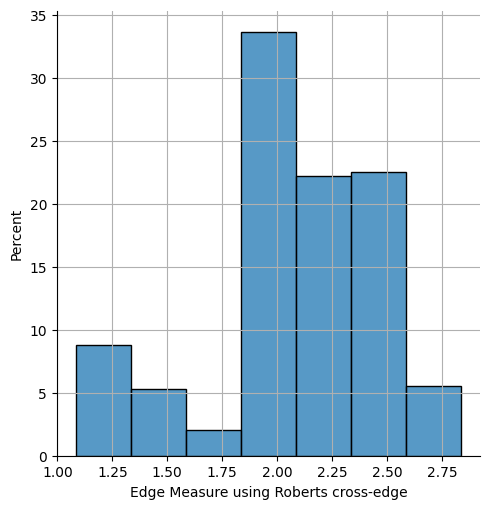

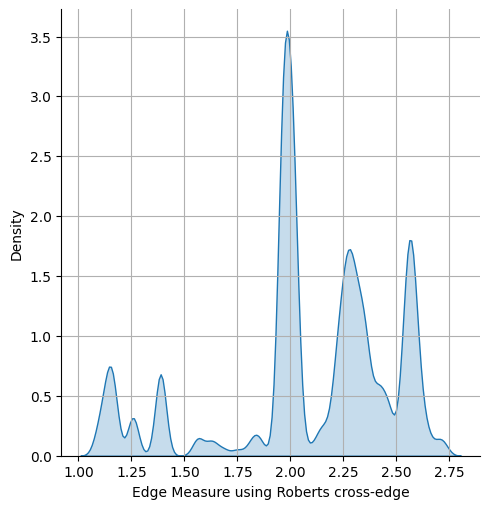

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.displot(gtg, fill=True, binwidth=2, stat='percent')
# plt.xlabel('Edge Measure using Tenegrad')
# plt.grid()

sns.displot(grc, fill=True, binwidth=0.25, stat='percent')
plt.xlabel('Edge Measure using Roberts cross-edge')
plt.grid()

sns.displot(grc, fill=True, kind='kde', bw_adjust=0.2)
plt.xlabel('Edge Measure using Roberts cross-edge')
plt.grid()

### for bad frames

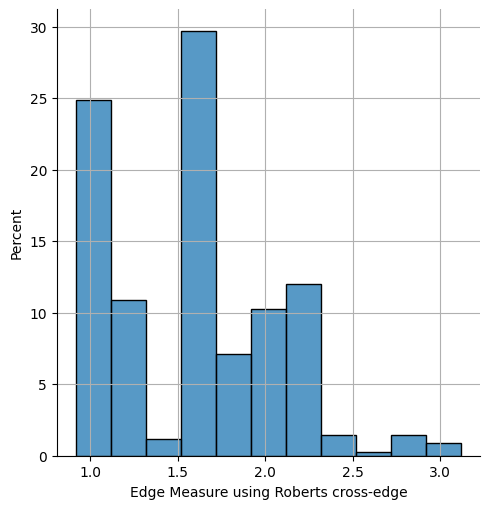

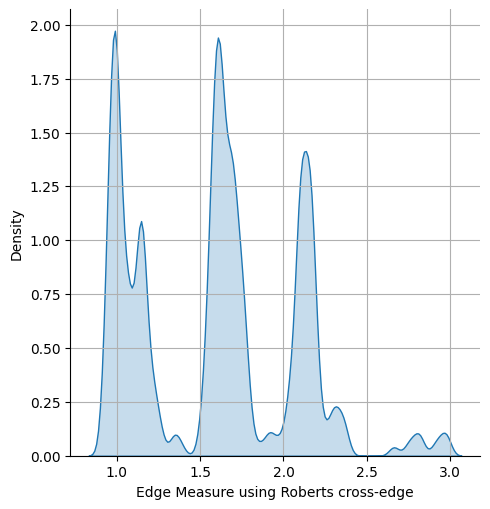

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.displot(btg, fill=True, binwidth=2, stat='percent')
# plt.xlabel('Edge Measure using Tenegrad')
# plt.grid()

sns.displot(brc, fill=True, binwidth=0.2, stat='percent')
plt.xlabel('Edge Measure using Roberts cross-edge')
plt.grid()

sns.displot(brc, fill=True, kind='kde', bw_adjust=0.2)
plt.xlabel('Edge Measure using Roberts cross-edge')
plt.grid()

### Threshold Optimization for Edge Measure Tenegrad

In [170]:
import pandas as pd

good_data = {
    'Label' : ['good' for i in range(0, len(gtg))],
    'Per' : gtg
}
bad_data = {
    'Label' : ['blur' for i in range(0, len(btg))],
    'Per' : btg
}

# creating a dataframe
df1 = pd.DataFrame(good_data)
df2 = pd.DataFrame(bad_data)
df = pd.concat([df1, df2], axis=0)
print(df)

    Label        Per
0    good  39.821920
1    good  36.115487
2    good  37.307927
3    good  29.866993
4    good  15.936422
..    ...        ...
345  blur  11.630902
346  blur  33.218992
347  blur  23.393439
348  blur  16.683053
349  blur  11.053895

[692 rows x 2 columns]


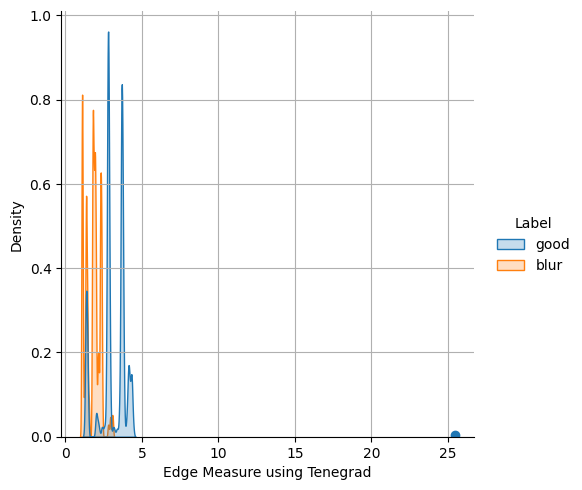

In [39]:
import seaborn as sns
from scipy.stats import gaussian_kde
from shapely.geometry import LineString

ax = sns.displot(df, x="Per", hue="Label", fill=True, kind='kde', bw_adjust=0.2)

# plt.plot(x[idx], kde2_x[idx], 'ko')
plt.xlabel('Edge Measure using Tenegrad')
# plt.vlines(x = 0.3435, ymin = 0, ymax = 10, color='red')
plt.plot(25.48734,0.00473, 'o')
plt.grid()

In [7]:
import pandas as pd

good_data = {
    'Label' : ['good' for i in range(0, len(grc))],
    'Per' : grc
}
bad_data = {
    'Label' : ['blur' for i in range(0, len(brc))],
    'Per' : brc
}

# creating a dataframe
df1 = pd.DataFrame(good_data)
df2 = pd.DataFrame(bad_data)
df = pd.concat([df1, df2], axis=0)
print(df)

    Label       Per
0    good  2.708984
1    good  2.255859
2    good  2.525391
3    good  2.003906
4    good  1.170898
..    ...       ...
345  blur  0.997070
346  blur  2.335938
347  blur  2.144531
348  blur  1.534180
349  blur  0.941895

[692 rows x 2 columns]


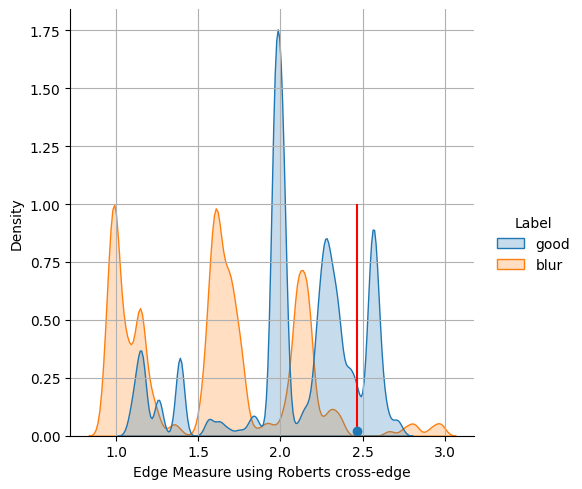

In [8]:
import seaborn as sns
from scipy.stats import gaussian_kde
from shapely.geometry import LineString

ax = sns.displot(df, x="Per", hue="Label", fill=True, kind='kde', bw_adjust=0.2)

# plt.plot(x[idx], kde2_x[idx], 'ko')
plt.xlabel('Edge Measure using Roberts cross-edge')
plt.vlines(x = 2.46734, ymin = 0, ymax = 1.0, color='red')
plt.plot(2.46734,0.019483, 'o')
plt.grid()

### extracting edge measure from test data

In [47]:
import time

blur_folder = r"D:\data\final_data\output\val\blur"
good_folder = r"D:\data\final_data\output\val\good"

b_files = os.listdir(blur_folder)
g_files = os.listdir(good_folder)


test_gtg = []
test_grc = []

st = time.time()

for f1 in g_files:
    path1 = os.path.join(good_folder, f1)
    img1 = cv2.imread(path1)
#     ghw.append(haar_wavelet(img1))
#     test_gtg.append(tenegrad(img1))
    test_grc.append(roberts_cross_edge(img1))
    
    
# print(glv)
# print(ghw)
# print(gtg)
# print(grc)
print('done.')

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

done.
Execution time: 18.578500986099243 seconds


In [48]:
test_btg = []
test_brc = []

for f2 in b_files:
    path2 = os.path.join(blur_folder, f2)
    img2 = cv2.imread(path2)
#     bhw.append(haar_wavelet(img2))
#     test_btg.append(tenegrad(img2))
    test_brc.append(roberts_cross_edge(img2))
    
# print(blv)
# print(bhw)
# print(btg)
# print(brc)

print('done.')

done.


### evaluating threshold on test data

In [145]:
tenegrad_t = 25.48734
roberts_t = 2.46734

In [149]:
TP = 0
TN = 0
FP = 0
FN = 0

for rl1,rl2 in zip(test_gtg, test_btg):
    if rl1 >= tenegrad_t:
        TP +=1
    else:
        FN +=1

    if rl2 >= tenegrad_t:
        FP += 1
    else:
        TN += 1

        
print(TP, TN, FP, FN)
print((TP+TN)/(TP+TN+FP+FN))

print(f'In test data: for choosen threshold=25.48734, TP={TP}, TN={TN}, FP={FP}, FN={FN}')

206 204 24 22
0.8991228070175439
In test data: for choosen threshold=25.48734, TP=206, TN=204, FP=24, FN=22


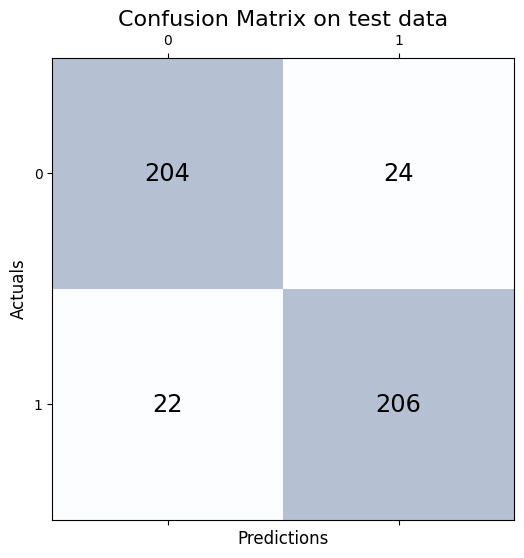

In [150]:
conf_matrix = np.matrix([[TN, FP], [FN, TP]])
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix on test data', fontsize=16)
plt.show()

In [151]:
total=TP+TN+FP+FN
# print(total)
#####from confusion matrix calculate accuracy
accuracy=(conf_matrix[0,0]+conf_matrix[1,1])/total
print ('Accuracy : ', accuracy)

recall = TP/(TP+FN)
print('Recall : ', recall)

precision = TP/(TP+FP)
print('Precision : ', precision)

Accuracy :  0.8991228070175439
Recall :  0.9035087719298246
Precision :  0.8956521739130435


In [152]:
TP = 0
TN = 0
FP = 0
FN = 0

for rl1,rl2 in zip(test_grc, test_brc):
    if rl1 >= roberts_t:
        TP +=1
    else:
        FN +=1

    if rl2 >= roberts_t:
        FP += 1
    else:
        TN += 1

        
print(TP, TN, FP, FN)
print((TP+TN)/(TP+TN+FP+FN))

print(f'In test data: for choosen threshold=2.46734, TP={TP}, TN={TN}, FP={FP}, FN={FN}')

196 219 9 32
0.9100877192982456
In test data: for choosen threshold=2.46734, TP=196, TN=219, FP=9, FN=32


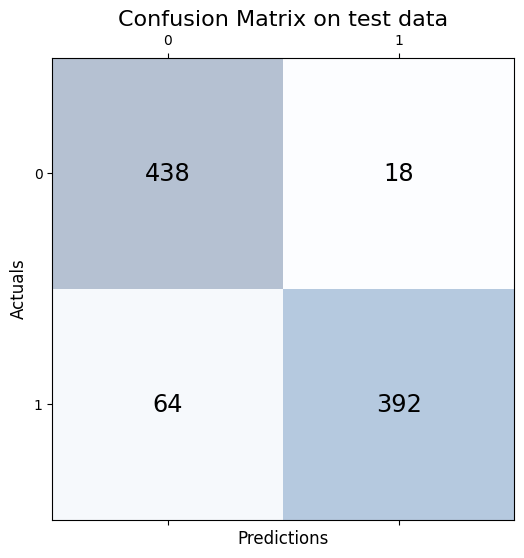

In [82]:
TP=196*2
TN=219*2
FP=9*2
FN=32*2

conf_matrix = np.matrix([[TN, FP], [FN, TP]])
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix on test data', fontsize=16)
plt.show()

In [83]:
total=TP+TN+FP+FN
# print(total)
#####from confusion matrix calculate accuracy
accuracy=(conf_matrix[0,0]+conf_matrix[1,1])/total
print ('Accuracy : ', accuracy)

recall = TP/(TP+FN)
print('Recall : ', recall)

precision = TP/(TP+FP)
print('Precision : ', precision)

Accuracy :  0.9100877192982456
Recall :  0.8596491228070176
Precision :  0.9560975609756097


In [118]:
import time



vid_path = r"D:\data\final_data\blur\blur1.mp4"

cap = cv2.VideoCapture(vid_path)

ret, frame = cap.read()
frame = cv2.resize(frame, (720, 1080))

st = time.time()
rl = roberts_cross_edge(frame)


if rl < 2.46734:
    print("dark")
else:
    print("bright")
    
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

dark
Execution time: 0.018997907638549805 seconds


### laplace 

In [135]:
def estimate_blur(image: np.array, threshold: int = 100):
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = cv2.GaussianBlur(image, (7, 7), 0)
    blur_map = cv2.Laplacian(image, cv2.CV_64F)
    score = np.var(blur_map)
    return blur_map, score, bool(score < threshold)

In [122]:
import time

blur_folder = r"D:\data\final_data\output\val\blur"
good_folder = r"D:\data\final_data\output\val\good"

b_files = os.listdir(blur_folder)
g_files = os.listdir(good_folder)

test_glap = []

st = time.time()

for f1 in g_files:
    path1 = os.path.join(good_folder, f1)
    img1 = cv2.imread(path1)
    _, s, _ = estimate_blur(img1)
#     ghw.append(haar_wavelet(img1))
#     test_gtg.append(tenegrad(img1))
    test_glap.append(s)
    
    
# print(glv)
# print(ghw)
# print(gtg)
# print(grc)
print('done.')

et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

done.
Execution time: 14.326895952224731 seconds


In [124]:
test_blap = []

for f2 in b_files:
    path2 = os.path.join(blur_folder, f2)
    img2 = cv2.imread(path2)
    _, s, _ = estimate_blur(img2)
#     bhw.append(haar_wavelet(img2))
#     test_btg.append(tenegrad(img2))
    test_blap.append(s)
    
# print(blv)
# print(bhw)
# print(btg)
# print(brc)

print('done.')

done.


In [153]:
print(test_glap)

[598.7721702200995, 634.7109034983304, 31.040189765360605, 30.542989285497157, 267.6887055701087, 554.3597638796958, 224.27670763451286, 196.34431054034238, 519.9552512392062, 630.3392298852239, 209.6686574057665, 225.96865734257116, 606.1488643722352, 578.1623976294198, 645.1872651796118, 432.9968354212957, 214.0545823680978, 677.863159138696, 232.0400197173044, 324.3418772751607, 318.4470095483262, 632.1943940988753, 265.0469638840663, 327.0140673010376, 612.3689680328263, 224.0542380330821, 227.53995369118596, 323.73876816462786, 202.37229937599471, 126.54704604617966, 219.27642071413106, 580.8963824455853, 498.49069344019597, 315.984355204547, 225.91906433375294, 624.3005895760808, 595.5978737136734, 513.2265685245768, 323.7049618657197, 313.9428621619091, 304.2284388469817, 212.96659288083717, 32.41240449459876, 590.9143873288181, 212.51861400390018, 672.069864815181, 307.7282952119692, 226.1800833841427, 639.4483929808708, 318.61885754145567, 209.76133294547583, 616.0214328929752

In [163]:
TP = 0
TN = 0
FP = 0
FN = 0

for rl1,rl2 in zip(test_glap, test_blap):
    if rl1 >= 210.0:
        TP +=1
    else:
        FN +=1

    if rl2 >= 8.0:
        FP += 1
    else:
        TN += 1

        
print(TP, TN, FP, FN)
print((TP+TN)/(TP+TN+FP+FN))

print(f'In test data: for choosen threshold=2.46734, TP={TP}, TN={TN}, FP={FP}, FN={FN}')

recall = TP/(TP+FN)
print('Recall : ', recall)

precision = TP/(TP+FP)
print('Precision : ', precision)

176 123 105 52
0.6557017543859649
In test data: for choosen threshold=2.46734, TP=176, TN=123, FP=105, FN=52
Recall :  0.7719298245614035
Precision :  0.6263345195729537


In [182]:
import time



vid_path = r"D:\data\final_data\blur\blur1.mp4"

cap = cv2.VideoCapture(vid_path)

ret, frame = cap.read()
frame = cv2.resize(frame, (360, 480))

st = time.time()
_,rl,_ = estimate_blur(frame)
print(rl)


if rl < 30.0:
    print("dark")
else:
    print("bright")
    
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

32.188558331189995
bright
Execution time: 0.003997802734375 seconds
